In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

from apps import cex_toy_generator, cex_toy_parameters
from IPython.display import clear_output
from python.analysis import cross_section, Plots

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
cross_section.SetPlotStyle(True, 100)


def CreateObservedInputData(toy : cross_section.Toy, bins : np.array, alt_regions : pd.DataFrame = None):
    toy_observed_binned = []

    reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

    for c in reco_regions:
        m = toy.df[c] if alt_regions is None else alt_regions[c]
        toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = bins)[0])
    return toy_observed_binned


def RegionFitStudy(toy : cross_section.Toy, model : cross_section.pyhf.Model, bins : np.array, alt_regions : pd.DataFrame = None, pdf : Plots.PlotBook = None):
    observed = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy, bins, alt_regions), model)
    result = cross_section.BackgroundFit.Fit(observed, model, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

    total_count_err = np.sum(np.power(postfit_pred.total_stdev_model_channels, 2))**0.5
    total_count = np.sum(postfit_pred.model_yields)
    total_count_actual = np.sum(prefit_pred.model_yields)

    print(f"{total_count_actual, total_count, total_count_err=}")

    # Plot fitted correlation matrix and actual
    plot = Plots.MultiPlot(2)
    next(plot)
    truth_regions_masksed = {t : toy.truth_regions[t] & (((toy.df.KE_int_smeared) > min(bins)) & ((toy.df.KE_int_smeared) < max(bins))) for t in toy.truth_regions}
    reco_regions_masksed = {r : toy.reco_regions[r] & (((toy.df.KE_int_smeared) > min(bins)) & ((toy.df.KE_int_smeared) < max(bins))) for r in toy.reco_regions} 
    counts_matrix = cross_section.Toy.ComputeCounts(truth_regions_masksed, reco_regions_masksed)
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False)
    next(plot)
    counts_matrix = []
    for c in postfit_pred.model_yields:
        counts_matrix.append([sum(s) for s in c])
    counts_matrix = np.array(counts_matrix, dtype = int).T
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "fitted", newFigure = False)

    if pdf is not None: pdf.Save()

    mu = {}
    for n in model.config.par_names:
        if "mu" in n:
            mu[f"$\{n}$"] = {"value" : result.bestfit[model.config.par_names.index(n)], "error" : result.uncertainty[model.config.par_names.index(n)]}
    mu = pd.DataFrame(mu)

    # Plot parameters of interest
    Plots.Plot(list(mu.columns), mu.iloc[0], yerr = mu.iloc[1], marker = "o", linestyle = "")
    Plots.plt.xticks(ticks = list(mu.columns), labels = list(mu.columns))
    if pdf is not None: pdf.Save()

    # Plot all fit parameters
    Plots.Plot(np.linspace(0, len(result.bestfit), len(result.bestfit)), result.bestfit, yerr = result.uncertainty, linestyle = "", marker = "o", markersize = 1, capsize = 2, xlabel = "fit parameter index", ylabel = "value")
    plt.ylim(0.75, 1.25)
    if pdf is not None: pdf.Save()

    # print table of parameters of interest
    print(mu.head())
    return result


def MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy, bins), model)
    mu = np.linspace(0, 2, 101)
    nll = []
    for m in mu:
        params_new = np.array(params)
        params_new[poi_ind] = m
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(mu, nll, xlabel = f"$\mu_{poi_ind}$", ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(mu[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | $\mu_{poi_ind}$={mu[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def CreateModelInputData(toy : cross_section.Toy, bins : np.array):
    model_input_data = []
    for c in toy.df.filter(regex = "reco_regions"):
        tmp = []
        for s in toy.df.filter(regex = "truth_regions"):
            tmp.append(np.histogram(toy.df.KE_int_smeared[toy.df[c] & toy.df[s]], bins = bins)[0])
        model_input_data.append(tmp)
    return model_input_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [27]:
toy_input = cross_section.Toy("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", True)
energy_slice = cross_section.Slices(50, 0, 1050, True)
bins = np.sort(energy_slice.pos)
model = cross_section.BackgroundFit.CreateModel(4, CreateModelInputData(toy_input, bins), True)
cross_section.BackgroundFit.PrintModelSpecs(model)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 21, 'channel_1': 21, 'channel_2': 21, 'channel_3': 21}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor'), ('sample_0_pois_err_0', 'shapesys'), ('sample_0_pois_err_1', 'shapesys'), ('sample_0_pois_err_2', 'shapesys'), ('sample_0_pois_err_3', 'shapesys'), ('sample_1_pois_err_0', 'shapesys'), ('sample_1_pois_err_1', 'shapesys'), ('sample_1_pois_err_2', 'shapesys'), ('sample_1_pois_err_3', 'shapesys'), ('sample_2_pois_err_0', 'shapesys'), ('sample_2_pois_err_1', 'shapesys'), ('sample_2_pois_err_2', 'shapesys'), ('sample_2_pois_err_3', 'shapesys'), ('sample_3_pois_err_0', 'shapesys'), ('sample_3_pois_err_1', 'shapesys'), ('sample_3_pois_err_2', 'shapesys'), ('sample_3_pois_err_3', 'shapesys')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3', 'sample_0_pois_err_0', 'sample_0_pois_err_1', '

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(9850137.0, 9850137.000000006, 6002.205584116809)

$\mu_0$   $\mu_1$   $\mu_2$   $\mu_3$
value  1.000000  1.000000  1.000000  1.000000
error  0.000878  0.003058  0.000922  0.001902

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


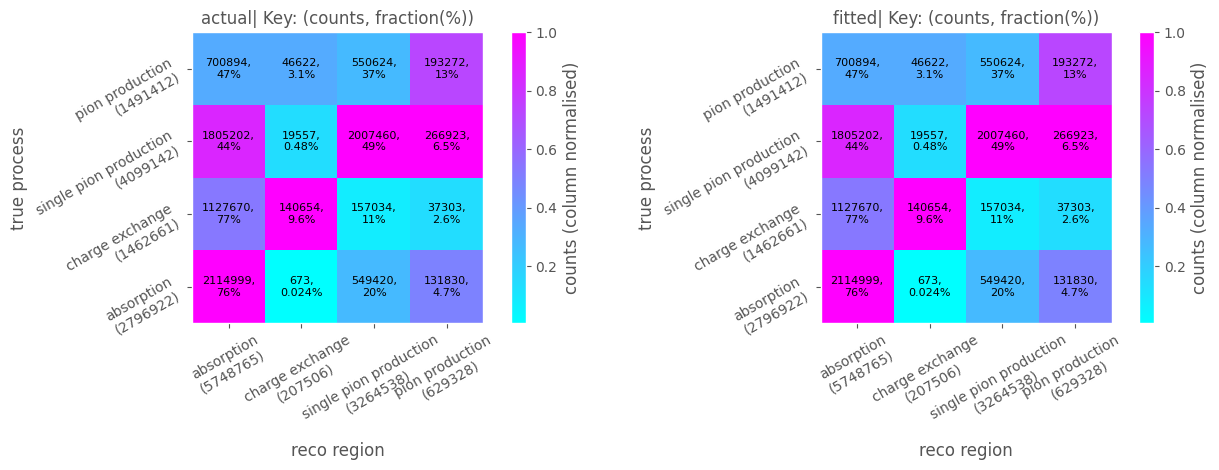

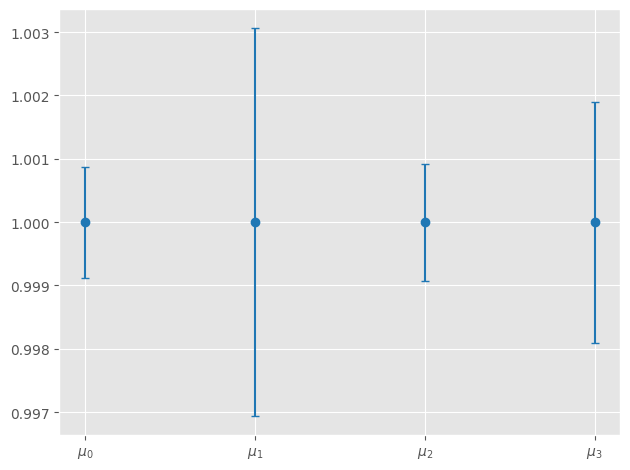

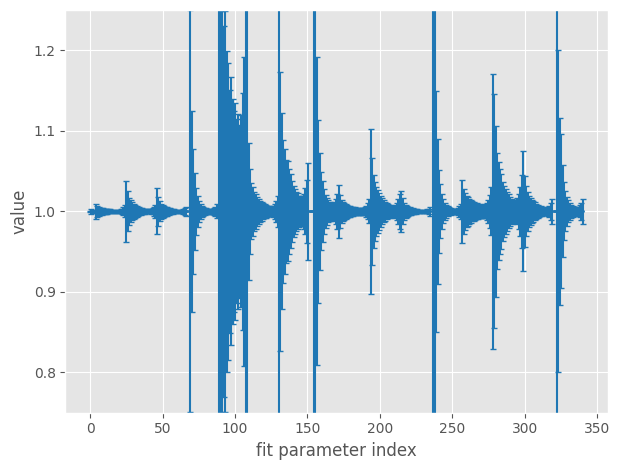

In [16]:
pdf = Plots.PlotBook("toy_validation_fit", False)
result = RegionFitStudy(toy_input, model, bins, pdf = pdf)
pdf.close()

# ProtoDUNE MC Stats

In [46]:
toy_PDSP_1GeV_config = {
    "events" : 50805,
    "step" : 2,
    "p_init" : 1000,
    "beam_profile" : "gaussian",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5"
}

In [70]:
def ComputePulls(toy_config : dict, model : cross_section.pyhf.Model):
    toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(toy_config)), smearing = True)
    clear_output(wait = True)
    observed = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy_observed, bins), model)
    result = cross_section.BackgroundFit.Fit(observed, model, False)

    unconstrained_params = [model.config.par_slice(i).start for i in model.config.par_names if "mu" in i]

    pulls = (result.bestfit - np.array(model.config.suggested_init())) / result.uncertainty
    return pulls[unconstrained_params]

In [95]:
def PullStudy(n : int, toy_config : dict, model : cross_section.pyhf.Model):
    pulls = []
    for i in range(n):
        pulls.append(ComputePulls(toy_PDSP_1GeV_config, model))
    pulls = np.array(pulls)

    norm_pulls = (pulls - np.mean(pulls, 0))/np.std(pulls, 0)
    for i in Plots.MultiPlot(4):
        Plots.PlotHist(norm_pulls[:, i], bins = 10, newFigure = False)
    return norm_pulls

In [101]:
pulls = PullStudy(100, toy_PDSP_1GeV_config, model)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

/tmp/ipykernel_25282/1088094862.py:9: RuntimeWarning: invalid value encountered in divide
  pulls = (result.bestfit - np.array(model.config.suggested_init())) / result.uncertainty


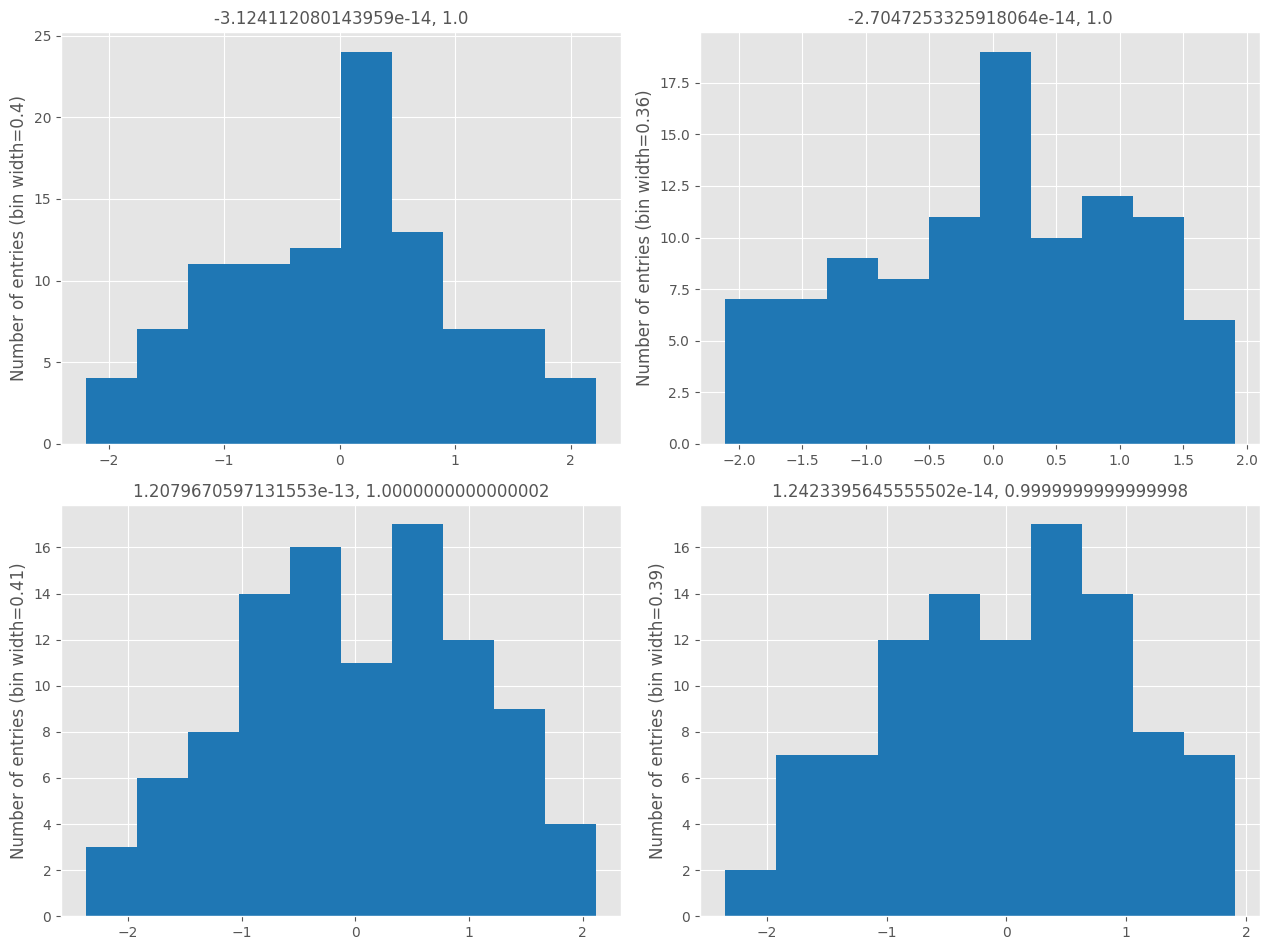

In [104]:
for i in Plots.MultiPlot(4):
    Plots.PlotHist(pulls[:, i], bins = 10, title = f"{np.mean(pulls[:, i])}, {np.std(pulls[:, i])}", newFigure = False)

In [53]:
toy_observed = cex_toy_generator.main(cex_toy_generator.ResolveConfig(toy_PDSP_1GeV_config))

starting batch : 0, cpus : 1

Done! Creating dataframe...

total_inelastic 50493

decay 312

charge_exchange 7418

absorption 14463

quasielastic 18326

pion_production 7671

double_charge_exchange 2615

312

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:245: RuntimeWarning: invalid value encountered in power
  E1 = A * (B-z)**(-p4)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:246: RuntimeWarning: invalid value encountered in power
  E2 = C * (D+z)**(-p6)


'Smearing' executed in 0.1100s

'BeamSelectionEfficiency' executed in 0.0036s

'GenerateRecoRegions' executed in 0.0523s

'main' executed in 5.6311s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(9850137.0, 50093.22590311484, 705.1827028600267)

$\mu_0$   $\mu_1$   $\mu_2$   $\mu_3$
value  0.004886  0.005322  0.005371  0.004443
error  0.000148  0.000237  0.000149  0.000365

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


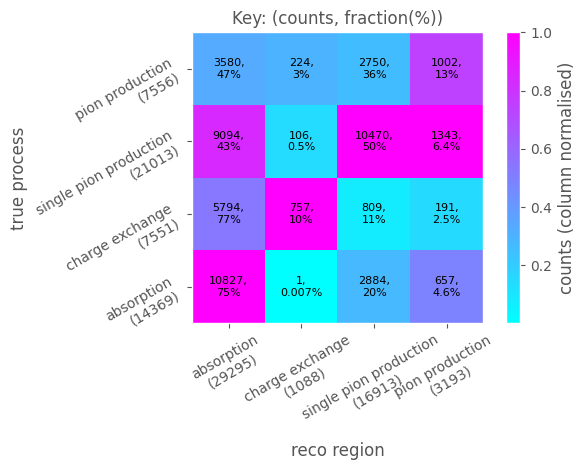

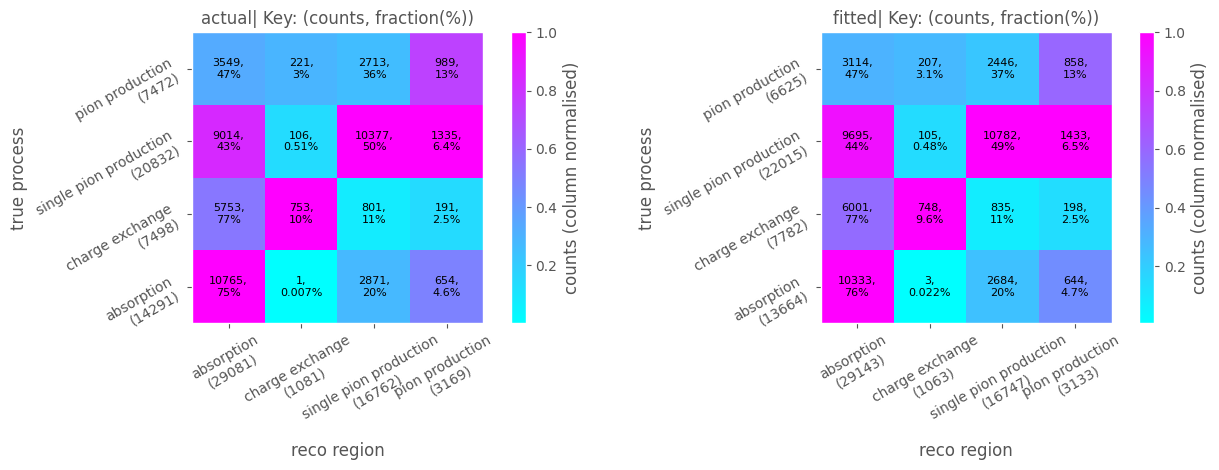

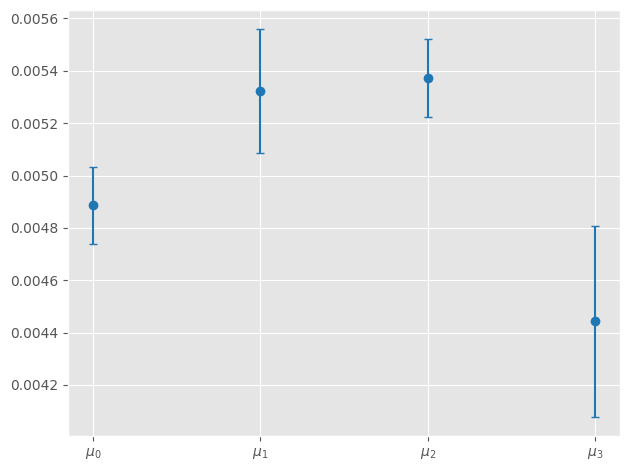

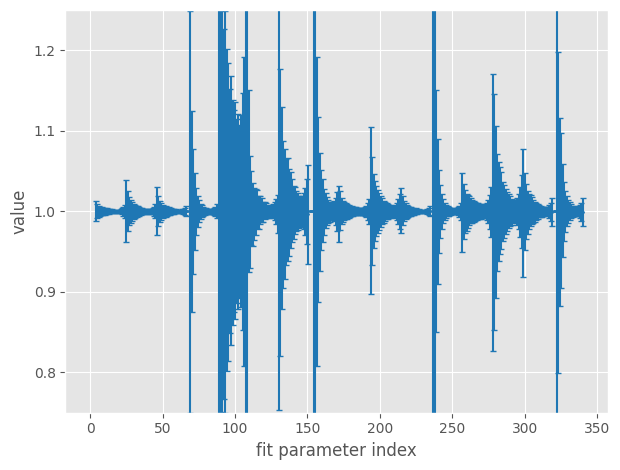

In [50]:
toy_observed = cross_section.Toy(df = toy_observed, smearing = True)
true_counts = cross_section.Toy.ComputeCounts(toy_observed.truth_regions, toy_observed.reco_regions)
cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_observed.truth_region_labels, toy_observed.reco_region_labels)

pdf_low_stats = Plots.PlotBook("toy_fit_low_stats.pdf", False)
result = RegionFitStudy(toy_observed, model, bins, pdf = pdf_low_stats)
pdf_low_stats.close()

# Alternate correlation matrix

In [ ]:
toy_alt = cross_section.Toy("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", True)
fractions = pd.read_hdf("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5")

print(fractions)

fractions["pion_production"]["pion_production"] += 0.25
fractions["pion_production"]["single_pion_production"] -= 0.25

# fractions["charge_exchange"]["charge_exchange"] += 0.1
# fractions["charge_exchange"]["absorption"] -= 0.1


print(fractions)

regions = cex_toy_generator.GenerateRecoRegions(toy_input.df.exclusive_process, fractions)

toy_alt._Toy__reco_regions = cross_section.Toy.GetRegion(regions, "reco_regions_")
toy_alt._Toy__truth_regions = cross_section.Toy.GetRegion(regions, "truth_regions_")


In [ ]:
pdf = Plots.PlotBook("toy_vary_regions.pdf", False)
cross_section.Toy.PlotObservablesInRegions(toy_alt.df.KE_int_smeared, toy_alt.reco_regions, toy_alt.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled", pdf = pdf)
result = RegionFitStudy(toy_alt, model, bins, toy_alt.reco_regions, pdf = pdf)
pdf.close()

# ABCD Method

In [ ]:
def ABCDModel(samples : np.array):
    channels = [
        {
            "name": f"channel_0",
            "samples":[
                {
                    "name" : f"sig_A",
                    "data" : samples[0][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_A",
                    "data" : samples[0][1].tolist(),
                    "modifiers" : [
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][1]).astype(int).tolist()}
                        ]
                },

            ]
        },
        {
            "name": f"channel_1",
            "samples":[
                {
                    "name" : f"sig_B",
                    "data" : samples[1][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_B",
                    "data" : samples[1][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_2",
            "samples":[
                {
                    "name" : f"sig_C",
                    "data" : samples[2][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_C",
                    "data" : samples[2][1].tolist(),
                    "modifiers" : [
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_3",
            "samples":[
                {
                    "name" : f"sig_D",
                    "data" : samples[3][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_D",
                    "data" : samples[3][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
    ]
    spec = {"channels" : channels}
    model = cross_section.pyhf.Model(spec, poi_name = "mu_sig")
    return model

def CreateModelInputDataABCD(toy : cross_section.Toy, signal : str, bins : np.array):
    samples_binned = []
    for r in toy.reco_regions:
        samples = []
        for t in toy.truth_regions:
            if t == "charge_exchange":
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & toy.truth_regions[t]], bins)[0])
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & ~toy.truth_regions[t]], bins)[0])
        samples_binned.append(samples)
    return samples_binned


def ABCD_MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy, bins, toy.reco_regions), model)
    # params = np.array(params)
    p = np.linspace(0, 2, 101)
    nll = []
    for i in p:
        params_new = np.array(params)
        params_new[poi_ind] = i
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(p, nll, xlabel = model.config.par_names[poi_ind], ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(p[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | {model.config.par_names[poi_ind]}={p[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def ABCD_Study(toy_model : cross_section.Toy, toy_obs : cross_section.Toy, pdf : Plots.PlotBook):
    bins = np.linspace(0, 1050, 22)
    model_alt = ABCDModel(CreateModelInputDataABCD(toy_model, bins))
    observed = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy_obs, bins, toy_obs.reco_regions), model_alt)
    result = cross_section.BackgroundFit.Fit(observed, model_alt, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model_alt)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model_alt, fit_results = result)
    print(result)

    true_counts = cross_section.Toy.ComputeCounts(toy_obs.truth_regions, toy_obs.reco_regions)
    cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_obs.truth_region_labels, toy_obs.reco_region_labels)
    pdf.Save()

    titles = toy_model.reco_region_labels

    x = (bins[1:] + bins[:-1]) / 2
    for n, (i, j) in Plots.IterMultiPlot(list(zip(prefit_pred.model_yields, postfit_pred.model_yields))):
        Plots.Plot(x, i[4 + n], label = "prefit signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n].replace("_", " "), newFigure = False)
        Plots.Plot(x, i[n], label = "prefit bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    actual_yield = CreateModelInputDataABCD(toy_obs, bins)
    for n, (i, j, k) in Plots.IterMultiPlot(list(zip(actual_yield, postfit_pred.model_yields, postfit_pred.total_stdev_model_bins))):
        Plots.Plot(x, i[0], label = "actual signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n], newFigure = False)
        Plots.Plot(x, i[1], label = "actual bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], yerr = k[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], yerr = k[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    for i in Plots.MultiPlot(4):
        ABCD_MLEScan(toy_obs, model_alt, bins, i, model_alt.config.suggested_init())
    pdf.Save()
    return

In [ ]:
pdf_valid = Plots.PlotBook("toy_ABCD_valid.pdf", True)
ABCD_Study(toy_input, toy_input, pdf_valid)
pdf_valid.close()

In [ ]:
pdf_vary = Plots.PlotBook("toy_ABCD_vary_regions.pdf", True)
ABCD_Study(toy_input, toy_alt, pdf_vary)
pdf_vary.close()